In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
# Ignore deprecated warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [3]:

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [6]:
print(test_data.data.size())
print(test_data.targets.size())

torch.Size([10000, 28, 28])
torch.Size([10000])


In [7]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:

from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1),
    'test' : DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1)
}

In [9]:

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7b6d19aac970>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7b6d19aae7d0>}

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [12]:

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [13]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} ({100 * batch_idx / len(loaders['train']):0f}%)]\t{loss.item():.6f}")

In [14]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss: 0.4f}, Accuracy {correct}/{len(loaders['test'].dataset)}  ({100 * correct / len(loaders['test'].dataset):.0f}%\n)")

In [15]:

for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0 / 60000 (0.000000%)]	2.301531
Train Epoch: 1 [2000 / 60000 (3.333333%)]	2.275246
Train Epoch: 1 [4000 / 60000 (6.666667%)]	2.128224
Train Epoch: 1 [6000 / 60000 (10.000000%)]	2.086848
Train Epoch: 1 [8000 / 60000 (13.333333%)]	2.009896
Train Epoch: 1 [10000 / 60000 (16.666667%)]	1.932858
Train Epoch: 1 [12000 / 60000 (20.000000%)]	1.866559
Train Epoch: 1 [14000 / 60000 (23.333333%)]	1.835525
Train Epoch: 1 [16000 / 60000 (26.666667%)]	1.774478
Train Epoch: 1 [18000 / 60000 (30.000000%)]	1.731989
Train Epoch: 1 [20000 / 60000 (33.333333%)]	1.702227
Train Epoch: 1 [22000 / 60000 (36.666667%)]	1.709560
Train Epoch: 1 [24000 / 60000 (40.000000%)]	1.724619
Train Epoch: 1 [26000 / 60000 (43.333333%)]	1.691672
Train Epoch: 1 [28000 / 60000 (46.666667%)]	1.751490
Train Epoch: 1 [30000 / 60000 (50.000000%)]	1.712511
Train Epoch: 1 [32000 / 60000 (53.333333%)]	1.658709
Train Epoch: 1 [34000 / 60000 (56.666667%)]	1.590221
Train Epoch: 1 [36000 / 60000 (60.000000%)]	1.660301
Trai

Prediction: 7


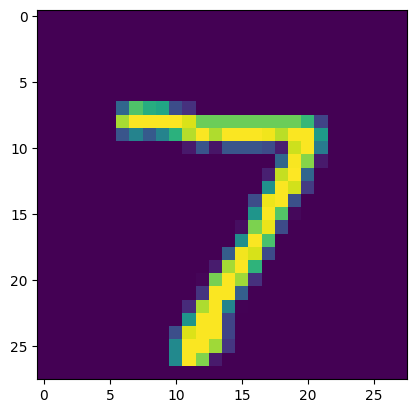

In [16]:
import matplotlib.pyplot as plt
model.eval()
data, target = test_data[0]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f"Prediction: {prediction}")
image = data.squeeze(0).squeeze(0).numpy()

plt.imshow(image);

Prediction: 0


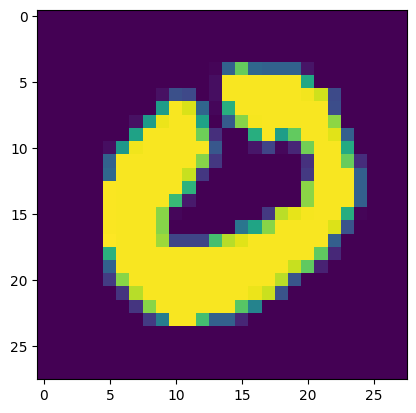

In [17]:

model.eval()
data, target = test_data[25]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f"Prediction: {prediction}")
image = data.squeeze(0).squeeze(0).numpy()

plt.imshow(image);

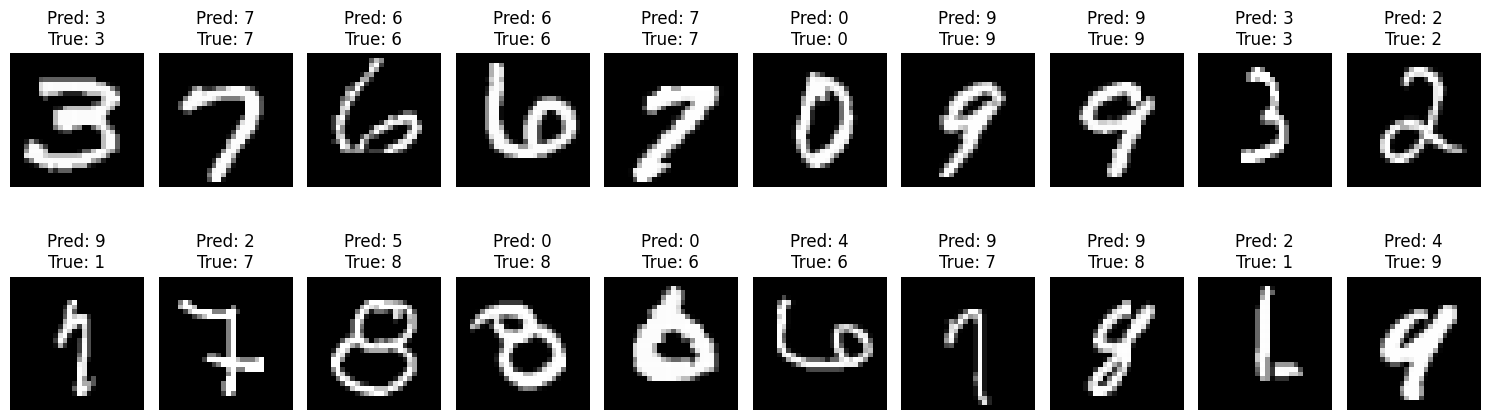

In [21]:
import matplotlib.pyplot as plt

def test_and_display_predictions():
    model.eval()
    correct_preds = []
    incorrect_preds = []

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            # Store correct predictions
            for i in range(len(target)):
                if pred[i] == target[i]:
                    correct_preds.append((data[i], pred[i], target[i]))
                else:
                    incorrect_preds.append((data[i], pred[i], target[i]))

            if len(correct_preds) >= 10 and len(incorrect_preds) >= 10:
                break

    # Display first 10 correct predictions
    plt.figure(figsize=(15, 5))
    for i in range(10):
        image, prediction, true_label = correct_preds[i]
        plt.subplot(2, 10, i + 1)
        plt.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
        plt.title(f'Pred: {prediction.item()}\nTrue: {true_label.item()}')
        plt.axis('off')

    # Display first 10 incorrect predictions
    for i in range(10):
        image, prediction, true_label = incorrect_preds[i]
        plt.subplot(2, 10, 10 + i + 1)
        plt.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
        plt.title(f'Pred: {prediction.item()}\nTrue: {true_label.item()}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
test_and_display_predictions()
